<a href="https://colab.research.google.com/github/yj-shin/yj-shin.github.io/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 # Load relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# **Flotation Data**

데이터 세트는 역 양이온 부양 방법을 사용하여 규소와 철광석을 분리하는 광물 처리 공장에서 얻었다. 연속 공정 데이터는 2017년 3월 10일 오전 1시부터 2017년 9월 9일 오후 11시까지 수집되었다.

각 데이터 행은 다음과 같이 네 가지 유형으로 분류할 수 있는 23개의 측정치로 구성된다.

원자재(2-3열);
환경 변수(4-8열);
공정 변수(9-22열);
가공 재료(23-24열).
원재료와 가공자재는 매 시간마다 표본이 추출되고 나머지는 매 20초마다 표본이 추출된다.

In [ ]:
filepath = '/content/drive/MyDrive/test/'
filename = 'MiningProcess_Flotation_Plant_Database.csv'
cols_renamed = [
    'date',          # Timestamp of measurements, formatted YYYY-MM-DD HH:MM:SS
    'feed_iron',     # %Iron (valuables) in the ore being fed into the flotation cell
    'feed_silica',   # %Silica (gangue) in the ore being fed into the cell
    'starch_flow',   # Amount of starch (reagent) added into the cell, measured in m^3/h
    'amina_flow',    # Amount of amina (reagent) added into the cell, measured in m^3/h
    'pulp_flow',     # Amount of ore pulp fed into the cell, measured in tonnes/hour
    'pulp_ph',       # Acidity/alkalinity of ore pulp on a scale of 0-14
    'pulp_density',  # Amount of ore in the pulp, between 1-3 kg/cm^3
    'air_col1',      # Volume of air injected into the cell, measured in Nm3/h
    'air_col2',
    'air_col3',
    'air_col4',
    'air_col5',
    'air_col6',
    'air_col7',
    'level_col1',    # Froth height in the cell, measured in mm
    'level_col2',
    'level_col3',
    'level_col4',
    'level_col5',
    'level_col6',
    'level_col7',
    'conc_iron',     # Lab measurement: %Iron in the end of flotation process
    'conc_silica']   # Lab measurement: %Silica in the end of flotation process
df = pd.read_csv(
    filepath+filename,
    header=0,
    names=cols_renamed,
    parse_dates=['date'],
    infer_datetime_format=True,
    decimal=',')
df.head()

,date,feed_iron,feed_silica,starch_flow,amina_flow,pulp_flow,pulp_ph,pulp_density,air_col1,air_col2,air_col3,air_col4,air_col5,air_col6,air_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,conc_iron,conc_silica
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,295.096,306.4,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,295.096,306.4,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,295.096,306.4,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,250.049,295.096,306.4,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,249.895,295.096,306.4,249.983,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


# Data Info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          737453 non-null  datetime64[ns]
 1   feed_iron     737453 non-null  float64       
 2   feed_silica   737453 non-null  float64       
 3   starch_flow   737453 non-null  float64       
 4   amina_flow    737453 non-null  float64       
 5   pulp_flow     737453 non-null  float64       
 6   pulp_ph       737453 non-null  float64       
 7   pulp_density  737453 non-null  float64       
 8   air_col1      737453 non-null  float64       
 9   air_col2      737453 non-null  float64       
 10  air_col3      737453 non-null  float64       
 11  air_col4      737453 non-null  float64       
 12  air_col5      737453 non-null  float64       
 13  air_col6      737453 non-null  float64       
 14  air_col7      737453 non-null  float64       
 15  level_col1    737

# Preprocessing Time-Series Data

시계열 데이터의 빈도를 시간당 기준으로 줄이기 위해 열 날짜를 다시 샘플링 한다. 이는 각 시간의 첫 번째 측정치만 선택하여 수행된다.

In [ ]:
# Resample data to hourly basis
df = df.set_index('date').resample('H').first()
df.shape

(4415, 23)

데이터를 검사한 결과 2017-03-16 06:00 ~ 2017-03-29 11:00 사이에 결측값이 포함된 318개의 행이 발견되었다.

결측치는 시계열 데이터의 불연속성을 초래하고 예측에 악영향을 미칠 수 있다. 

따라서 2017-03-29 12:00부터 시작되는 데이터만 추가로 사용된다.

In [ ]:
nans = df[df.isna().any(axis=1)]  # Check for missing values
print(f'Total rows with NaNs: {nans.shape[0]}\n')
nans

Total rows with NaNs: 318



,feed_iron,feed_silica,starch_flow,amina_flow,pulp_flow,pulp_ph,pulp_density,air_col1,air_col2,air_col3,air_col4,air_col5,air_col6,air_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,conc_iron,conc_silica
date,,,,,,,,,,,,,,,,,,,,,,,
2017-03-16 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-29 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-29 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-29 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Remove data with time discontinuity
df = df['2017-03-29 12:00:00':]
df

,feed_iron,feed_silica,starch_flow,amina_flow,pulp_flow,pulp_ph,pulp_density,air_col1,air_col2,air_col3,air_col4,air_col5,air_col6,air_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,conc_iron,conc_silica
date,,,,,,,,,,,,,,,,,,,,,,,
2017-03-29 12:00:00,60.18,9.34,2044.990000,349.911,405.625000,9.74604,1.649650,200.393,195.734,201.826,295.096,306.400,250.601,251.002,555.264467,552.255566,614.984714,428.430,413.662,447.887,464.869,66.44,1.36
2017-03-29 13:00:00,60.18,9.34,2510.360000,306.635,402.303000,9.63786,1.524512,200.165,194.286,201.929,295.096,306.400,250.194,250.188,851.772761,809.863864,881.307250,447.543,421.279,446.697,413.322,66.57,1.43
2017-03-29 14:00:00,60.18,9.34,2138.230000,435.199,401.953000,9.61320,1.594940,199.540,197.436,198.605,295.096,306.400,250.460,250.488,850.510694,774.266870,886.773000,470.638,455.341,457.393,456.480,66.64,1.33
2017-03-29 15:00:00,60.18,9.34,458.079000,476.878,400.173000,9.75149,1.638440,199.951,191.456,199.265,295.096,306.400,247.809,249.582,858.052225,778.343085,883.777182,438.033,446.859,423.184,483.157,66.41,1.27
2017-03-29 16:00:00,59.54,9.56,145.349632,252.088,399.484000,9.96978,1.521080,199.072,182.430,201.251,295.096,306.400,250.488,250.760,853.745107,782.419299,883.715800,435.285,434.663,452.469,436.865,63.63,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,49.75,23.20,2888.060000,494.990,376.468000,9.27990,1.667860,317.065,297.754,301.685,300.583,300.593,297.551,302.330,577.943000,489.959000,504.995000,440.587,481.295,434.701,401.796,65.05,1.65
2017-09-09 20:00:00,49.75,23.20,4218.570000,492.027,378.630000,9.15799,1.648880,302.081,301.348,300.543,300.125,299.530,336.250,342.615,412.491000,510.388000,342.202000,371.883,594.518,443.687,375.044,64.83,1.71
2017-09-09 21:00:00,49.75,23.20,3159.100000,520.986,381.468667,9.58069,1.736200,296.063,298.480,299.085,299.130,299.588,350.652,332.393,401.456000,533.409000,390.060000,395.463,587.855,489.406,504.982,64.29,1.80


다음 그림은 부유 공정 전과 후의 광물 함량(농축액)을 보여준다. 

그림에서 관찰할 수 있듯이, 

부유물의 목적은 철 광물의 회수를 증가시키는 동시에 간구(실리카)를 감소시키는 것이다.

일부 기간 동안(예: 5월 13일부터 6월 13일까지), 사료에 함유된 미네랄 함량은 일정했지만 농축물 함량은 변동했다. 

이는 농축물 %철과 %silica가 원자재의 함량뿐만 아니라 다른 파라미터(즉, 환경, 공정 변수)에도 의해 제어된다는 것을 암시한다.

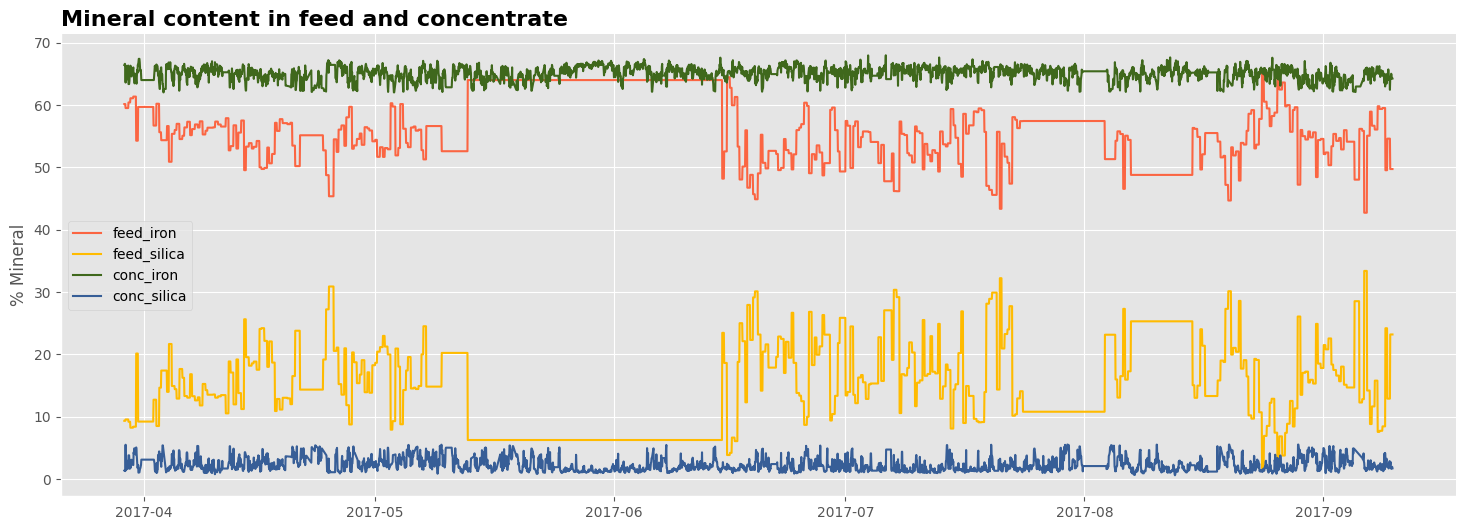

In [ ]:
content = ['feed_iron', 'feed_silica', 'conc_iron', 'conc_silica']
palette = ['#FB6542', '#FFBB00', '#3F681C', '#375E97']

# Plot mineral content before and after flotation
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18,6))
for pct, color in zip(content, palette):
    ax.plot(df.index.values, pct, data=df, color=color)
ax.set_title('Mineral content in feed and concentrate',
             loc='left', weight='bold', size=16)
ax.set_ylabel('% Mineral')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='center left')
plt.show()

%silica를 농축에 포함시키지 않고 농축에 대한 예측을 특성으로 보려고 하기 때문에 column conc_iron이 데이터 프레임에서 떨어진다. 

그런 다음 데이터는 서로 다른 단위와 척도를 가지므로 정규화 된다.

In [ ]:
cols = list(df)
cols.insert(0, cols.pop(         # Moving target `conc_silica` to the front
    cols.index('conc_silica')))  # Not necessary but I prefer to do so
df = df.loc[:, cols]
df.to_csv('./Flotation_Dataset_by_Hour.csv')  # For safekeeping

# Drop `conc_iron` then normalize all data
values = df.drop('conc_iron', axis=1).values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled[0]  # Show first element of the array

array([0.15415822, 0.75694444, 0.25023372, 0.32510961, 0.21746036,
       0.69332766, 0.4831859 , 0.38984084, 0.12485375, 0.09580737,
       0.19501985, 0.14419899, 0.94633739, 0.32903284, 0.31764479,
       0.56808723, 0.55238373, 0.64222035, 0.51514011, 0.48621123,
       0.53465188, 0.59964695])

전처리 단계에는 이전 시간 단계(t-n)의 매개변수(즉, 원자재, 환경, 프로세스)가 주어진 현재 시간(t)에 집중된 %silica를 예측하는 감독 학습 문제로 데이터 세트를 프레임화하는 것이 포함된다. 

Jason Brownlee의 블로그 Machine Learning Mastery에서 채택한 아래의 series_to_supervised() 함수를 사용하여 데이터 세트를 변환한다.

In [ ]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):   # Input sequence (t-n, ... t-1)
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):      # Forecast sequence (t, t+1, ... t+n)
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    agg = pd.concat(cols, axis=1)  # Put it all together
    agg.columns = names
    if dropnan:                    # Drop rows with NaN values
        agg.dropna(inplace=True)
        
    # Drop columns we don't want to predict
    drop_cols = ['var'+str(i)+'(t)' for i in range(2,23)]
    agg.drop(columns=drop_cols, axis=1, inplace=True)   
    return agg

In [ ]:
reframed = series_to_supervised(scaled, n_in=1, n_out=1)
reframed  # Show reframed dataset

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var1(t)
1,0.154158,0.756944,0.250234,0.325110,0.217460,0.693328,0.483186,0.389841,0.124854,0.095807,0.195020,0.144199,0.946337,0.329033,0.317645,0.568087,0.552384,0.642220,0.515140,0.486211,0.534652,0.599647,0.168357
2,0.168357,0.756944,0.250234,0.399114,0.130491,0.614810,0.430529,0.014039,0.123694,0.088174,0.195827,0.144199,0.946337,0.326752,0.313026,0.986143,0.969781,0.992805,0.552195,0.501239,0.532443,0.492095,0.148073
3,0.148073,0.756944,0.250234,0.339937,0.388859,0.606538,0.418525,0.225542,0.120515,0.104780,0.169777,0.144199,0.946337,0.328243,0.314728,0.984364,0.912104,1.000000,0.596969,0.568442,0.552298,0.582143,0.135903
4,0.135903,0.756944,0.250234,0.072755,0.472618,0.564466,0.485839,0.356177,0.122605,0.073255,0.174949,0.144199,0.946337,0.313385,0.309587,0.994997,0.918708,0.996056,0.533758,0.551708,0.488795,0.637805,0.993915
5,0.993915,0.729167,0.257089,0.023025,0.020871,0.548181,0.592093,0.003732,0.118134,0.025672,0.190514,0.144199,0.946337,0.328400,0.316272,0.988924,0.925313,0.995976,0.528430,0.527645,0.543158,0.541217,0.210953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943,0.249493,0.304253,0.682144,0.494607,0.513934,0.163464,0.328183,0.396119,0.628798,0.675804,0.938009,0.487274,0.592609,0.614199,0.584263,0.365708,0.488878,0.344877,0.427605,0.573162,0.428127,0.373888,0.212982
3944,0.212982,0.304253,0.682144,0.459176,0.509017,0.004184,0.256289,0.444529,0.718317,0.633630,0.977617,0.586296,0.669616,0.592163,0.608914,0.600062,0.451446,0.497431,0.538709,0.619649,0.510174,0.468046,0.225152
3945,0.225152,0.304253,0.682144,0.670757,0.503062,0.055284,0.196949,0.387530,0.642099,0.652577,0.968668,0.549394,0.618961,0.809050,0.837517,0.366786,0.484547,0.283132,0.405512,0.843034,0.526855,0.412228,0.243408
3946,0.243408,0.304253,0.682144,0.502278,0.561259,0.122377,0.402701,0.649761,0.611488,0.637457,0.957241,0.469225,0.621725,0.889766,0.779511,0.351228,0.521847,0.346131,0.451227,0.829888,0.611724,0.683342,0.275862


var22(t-1)까지의 열 var1(t-1)이 특징/입력입니다. 측정된 입력값은 목표값 var1(t) 1시간 전에 지연된다(시간 t에 농축된 %silica).

변환된 데이터는 교육(60%), 검증(20%), 테스트(20%)의 세 가지 세트로 더 세분화됩니다. 2017-03-29 12:00 ~ 2017-08-08 00:00 사이의 부양 데이터는 총 3157시간 교육/검증 목적으로 사용된다.

In [ ]:
n_features = 22             # Number of inputs for forecast
n_hours = 1                 # Number of hours with which to lag features
n_obs = n_hours*n_features

# Define row size of each split
n_train = int(np.round(len(reframed)*.60))
n_valid = int(np.round(len(reframed)*.20))
n_test = int(np.round(len(reframed)*.20))

# Split dataset by row size
values = reframed.values
train = values[:n_train, :]
valid = values[n_train:(n_train+n_valid), :]
test = values[(n_train+n_valid):, :]

# Each set further split into inputs/features (X) and output (y)
train_X, train_y = train[:, :n_obs], train[:, -1]
valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

# Reshape inputs (X) to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
valid_X = valid_X.reshape((valid_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print(  # Show the final shape of each set
    f'Training set  : {train_X.shape}, {train_y.shape}',
    f'\nValidation set: {valid_X.shape}, {valid_y.shape}',
    f'\nTesting set   : {test_X.shape}, {test_y.shape}')

Training set  : (2368, 1, 22), (2368,) 
Validation set: (789, 1, 22), (789,) 
Testing set   : (790, 1, 22), (790,)


# Building and Training Model

부선 농축액을 잘 섞어 맥석 대안은 시계열과 관련된 문제이다.

문제를 해결하기 위해 구현될 수 있는 반복되는 신경 네트워크(RNN)의 변형된, 

긴 단기 기억(LSTM)라고 하는 깊은 학습 방법이다.

LSTMs 많은 면에서 기존의 피드 포워드로는 신경 네트워크와 RNN에 비해 경쟁 우위를 점하고 있다.



이 선택적으로 시간의 장시간. 패턴 -Analytics Vidhya 기억하는 그들의 속성 때문이다.

모형 건설과 훈련 Keras, 파이선 심도 있는 학습 도서관으로 수행한다.

그 모델은 두가지 LSTM 층, 각 16기억 세포들과 함께의 열, 그리고fully-connected(고밀도)계층 순으로 따르구성되어 있다.

훈련에서, 그 자료는 16훈련 샘플의 미니 배치로 분류된다.

그 훈련 과정 100시대(패스의 한 시대는 전체 훈련 샘플 완수에 필요한)에 운영된다.

In [ ]:
# with tf.device('/device:GPU:0'):
model = Sequential([   # Define a sequential model
    LSTM(units=16,
         return_sequences=True,
         input_shape=(train_X.shape[1],
                      train_X.shape[2])),
    LSTM(units=16),
    Dense(1)
])
model.compile(
    loss='mse',        # Mean absolute error
    optimizer='adam')  # Learning rate = 0.001     // optimizer='adam')
model.summary()        # Display model's architecture

from tensorflow.keras.layers import concatenate


# def create_lstm(dim)
#     model = Sequential([   # Define a sequential model
#         LSTM(units=dim,
#             return_sequences=True,
#             input_shape=(train_X.shape[1],
#                           train_X.shape[2])),
#         LSTM(units=dim),
#         Dense(4)
#     ])
#     return model

# mlp=models.create_mlp(8) 
# lstm=models.create_lstm(16)
# combinedInput = concatenate([mlp.output, lstm.output])
# x = Dense(4, activation="relu")(combinedInput)
# x = Dense(1, activation="linear")(x)

# model = Model(inputs=[mlp.input, cnn.input], outputs=x)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 1, 16)             2496      
_________________________________________________________________
lstm_21 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 4,625
Trainable params: 4,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(   # Fit on training data
    train_X,
    train_y,
    epochs=100,
    batch_size=16,
    validation_data=(  # Supply validation data
        valid_X,
        valid_y),
    verbose=2,
    shuffle=False,
    callbacks=ModelCheckpoint(  # Save model
        './LSTM_Flotation_Gangue.hdf5'))

Epoch 1/100
148/148 - 5s - loss: 0.0690 - val_loss: 0.0470
Epoch 2/100
148/148 - 1s - loss: 0.0469 - val_loss: 0.0444
Epoch 3/100
148/148 - 1s - loss: 0.0428 - val_loss: 0.0412
Epoch 4/100
148/148 - 1s - loss: 0.0375 - val_loss: 0.0363
Epoch 5/100
148/148 - 1s - loss: 0.0311 - val_loss: 0.0301
Epoch 6/100
148/148 - 1s - loss: 0.0258 - val_loss: 0.0255
Epoch 7/100
148/148 - 1s - loss: 0.0234 - val_loss: 0.0235
Epoch 8/100
148/148 - 1s - loss: 0.0222 - val_loss: 0.0227
Epoch 9/100
148/148 - 1s - loss: 0.0215 - val_loss: 0.0223
Epoch 10/100
148/148 - 1s - loss: 0.0211 - val_loss: 0.0222
Epoch 11/100
148/148 - 1s - loss: 0.0209 - val_loss: 0.0221
Epoch 12/100
148/148 - 1s - loss: 0.0208 - val_loss: 0.0220
Epoch 13/100
148/148 - 1s - loss: 0.0207 - val_loss: 0.0220
Epoch 14/100
148/148 - 1s - loss: 0.0207 - val_loss: 0.0220
Epoch 15/100
148/148 - 1s - loss: 0.0207 - val_loss: 0.0221
Epoch 16/100
148/148 - 1s - loss: 0.0206 - val_loss: 0.0221
Epoch 17/100
148/148 - 1s - loss: 0.0206 - val_lo

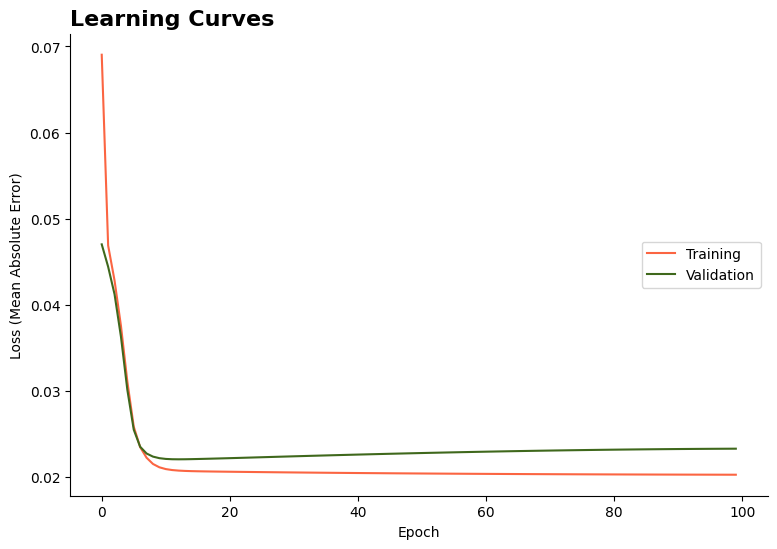

In [ ]:
# Extract losses from training history
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

# Plot learning curves
#plt.style.use('ggplot')
plt.style.use('default')
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(train_loss, color=palette[0], label='Training')
ax.plot(valid_loss, color=palette[2], label='Validation')
ax.set_title('Learning Curves', loc='left', weight='bold', size=16)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Mean Absolute Error)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='center right')
plt.show()

In [ ]:
# # Extract losses from training history
# train_loss = history.history['loss']
# valid_loss = history.history['val_loss']

# # Plot learning curves
# #plt.style.use('ggplot')
# plt.style.use('default')
# fig, ax = plt.subplots(figsize=(9,6))
# ax.plot(train_loss, color=palette[0], label='Training')
# ax.plot(valid_loss, color=palette[2], label='Validation')
# ax.set_title('Learning Curves', loc='left', weight='bold', size=16)
# ax.set_xlabel('Epoch')
# ax.set_ylabel('Loss (Mean Squared Error)')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.legend(loc='center right')
# plt.show()

위의 그림은 훈련 및 검증 손실이 안정점으로 감소하고 두 값 사이에 간격이 최소인 모형이 적합하다는 것을 나타낸다.

In [ ]:
print(f'Best training loss   = {min(train_loss):.4f}',
      f'at epoch {train_loss.index(min(train_loss))}',
      f'\nBest validation loss = {min(valid_loss):.4f}',
      f'at epoch {valid_loss.index(min(valid_loss))}')

Best training loss   = 0.0202 at epoch 99 
Best validation loss = 0.0220 at epoch 12


# Forecasting with LSTM

예측은 훈련된 모델과 교육/검증 프로세스 중에 포함되지 않은 데이터를 사용하여 수행된다. 

예측값과 실제 값은 모형에 대한 오차 점수를 계산하기 전에 원래 척도로 다시 반전된다. 

예측 평가에서는 (1) 평균 절대 오차 및 (2) 루트 평균 제곱 오차라는 두 가지 오차 지표를 고려한다.

In [ ]:
# Make prediction using test features
yhat = model.predict(test_X)

# Reshape test data
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
test_y = test_y.reshape((len(test_y), 1))

# Invert scaling for forecasts
inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual values
inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate error scores
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
import math
import sklearn.metrics as metrics
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.linear_model import LinearRegression

# Optimal parameters defined on a separate script by iterations
# params = {
#     'n_estimators': 80,
#     'max_depth': 12,
#     'learning_rate': 0.1,
#     'criterion': 'mse'
#     }

# # GBR implementation
# gbr = ensemble.GradientBoostingRegressor(**params)
# gbr.fit(train_X,train_y)

# regressor_mlr = LinearRegression()
# regressor_mlr.fit(test_X,test_y) #x trainden y traini öğren 

# y_pred_mlr = regressor_mlr.predict(test_X)
# print('R2 Score of Multi Linear Regression',r2_score(test_y,y_pred_mlr))


mae = mean_absolute_error(inv_y, inv_yhat)
mse = mean_squared_error(inv_y, inv_yhat)
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
# r2 = r2_score(test_y,y_pred_mlr)

# metric = tfa.metrics.r_square.RSquare()
# metric.update_state(y_true, y_pred)
# result = metric.result()
# result.numpy()


# err_score = RandomForestRegressor()
# err_score.fit(X,y)
print(32*'-'+'\nFORECAST EVALUATION'+'\n'+32*'-',
      f'\nMAE    : {mae:.4f}',
      f'\nRMSE: {rmse:.4f}',
      f'\nMSE: {mse:.4f}' #,
      # f'\nr2: {r2:.4f}'
      )

NameError: ignored

In [ ]:
# Define date as x-axis
test_date = df.index[-test_y.shape[0]:]

# Confidence interval 95% (Z-value 1.96)
ci = 1.96*np.std(inv_y)/np.mean(inv_y)

# Plot actual values and forecasts
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(test_date, inv_y, color=palette[1], label='Actual Value')
ax.plot(test_date, inv_yhat, color=palette[2], label='Forecast')
ax.fill_between(test_date, (inv_y-ci), (inv_y+ci), color=palette[3],
                alpha=.1, label='95% Confidence Interval')
ax.set_title('%Silica in Concentrate: Actual Values and Forecasts by LSTM',
             loc='left', weight='bold', size=16)
ax.set_ylabel('Silica in Concentrate (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()


농도 %silica의 예측값과 실제 값의 비교는 오전 1시 사이의 기간에 대해 위에 표시된다. 

2017년 8월 8일 오후 11시. 2017년 9월 9일. 예측값은 대부분 실제 값의 패턴을 따르며 95% 신뢰 구간 내에 포함된다.

# Forecast Comparison with Random Forest: 랜덤 포레스트와의 예측 비교

LSTM에 비해 랜덤 포리스트 회귀 분석기는 더 큰 오차를 생성하고 장기 예측에 대해 잘 수행되지 않을 수 있다.

In [ ]:
# Reframe data by lagging features by 1 hour
rf_values = df.drop('conc_iron', axis=1).values
rf_reframed = series_to_supervised(rf_values, n_in=1, n_out=1)

# Define features and target
rf_X = rf_reframed.values[:, :-1]
rf_y = rf_reframed.values[:, -1]

# Split data into train/test sets (80/20)
rf_train_X, rf_test_X, rf_train_y, rf_test_y = train_test_split(
    rf_X, rf_y, test_size=.20, random_state=0, shuffle=False)

# Normalize features
rf_scaler = MinMaxScaler(feature_range=(0,1))
rf_train_X = rf_scaler.fit_transform(rf_train_X)
rf_test_X = rf_scaler.transform(rf_test_X)

# Instantiate regressor
forest = RandomForestRegressor(random_state=0)

# Fit model on training data
forest.fit(rf_train_X, rf_train_y)

# Make prediction using trained model
rf_yhat = forest.predict(rf_test_X)

# Calculate error scores
rf_mae = mean_absolute_error(rf_test_y, rf_yhat)
rf_mse = mean_squared_error(inv_y, inv_yhat)
rf_rmse = np.sqrt(mean_squared_error(rf_test_y, rf_yhat))
print(32*'-'+'\nFORECAST EVALUATION'+'\n'+32*'-',
      f'\nMean absolute error    : {rf_mae:.4f}',
      f'\nRoot mean squared error: {rf_rmse:.4f}',
      f'\nMSE: {rf_mse:.4f}')

In [ ]:
# Plot actual values and forecasts
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(test_date, rf_test_y, color=palette[1], label='Actual Value')
ax.plot(test_date, rf_yhat, color=palette[2], label='Forecast')
ax.fill_between(test_date, (rf_test_y-ci), (rf_test_y+ci), color=palette[3],
                alpha=.1, label='95% Confidence Interval')
ax.set_title('%Silica in Concentrate: Actual Values and Forecasts by Random Forest',
             loc='left', weight='bold', size=16)
ax.set_ylabel('Silica in Concentrate (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()

In [ ]:
model.summary()

In [ ]:
# scores = evaluate(rf_test_X, rf_test_y, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

# import tensorflow as tf

# metric = tf.keras.metrics.BinaryAccuracy()
# acc = metric(inv_y, inv_yhat)
# print(acc)

# model.compile(optimizer='sgd',
#               loss='mse',
#               metrics=[tf.keras.metrics.BinaryAccuracy()])



# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()


# def eval_accuracy(output, y): 
#   mdiff = np.mean(np.abs((output - y)/y)) 
#   return 1 - mdiff

# learning_rate = 0.1
# abalone_exec(epoch_count=100, mb_size=100, report=20)


# model.fit(rf_train_X, rf_train_y, batch_size=100, epochs=10, validation_data=(rf_test_X, rf_test_y))

# result = model.evaluate(rf_test_X, rf_test_y)
# print("최종 예측 성공률(%): ", result[1]*100)

# Conclusion

LSTM을 이용한 딥러닝 접근 방식이 구현되어 부양 집중의 갠지스 콘텐츠를 예측했다.

특성에서 %silica 농도를 제외하고, 1시간 전에 %silica 농도를 예측했으며 오차는 1 미만이었다(RMSE, MAE 기준). 

이 포스트에서 데이터 세트 소유자가 언급한 바와 같이 MAE와 RMSE는 만족스러운 결과이다. 

따라서 예측 결과는 공정 엔지니어가 농도 순도를 적시에 평가하고 특히 순도가 허용 가능한 값에서 벗어날 때 미리 시정 조치를 취할 수 있는 유망한 방법을 보여준다.




마지막으로, 이 노트북의 LSTM 구현은 목표를 달성했지만, 추가 탐색을 통해 다음과 같은 이점을 얻을 수 있다.

더 작은 지연 시간 단계를 사용하여 예측한다. 

예를 들어, 기능/입력 시 30분 지연.
부유 공정의 어떤 매개변수가 %silica 농도에 큰 영향을 미치는지 이해하기 위한 형상 중요도 분석. 이것은 중요한 매개변수가 그에 따라 조정되도록 보장한다.